In [1]:
import numpy as np
def delete_label(statistics_result):
    label_column = statistics_result[:, :, 4*16:4*16+1]
    statistics_result = np.concatenate((statistics_result, label_column), axis=2)
    statistics_result = np.delete(statistics_result, np.s_[4*16:4*16+4], axis=2)
    return statistics_result

In [2]:
import pandas as pd
import numpy as np
def test_df_func(raw_data_test,model_pred,threshold):
    count_dict={}
    deleted_rn=[]
    for rn in raw_data_test['RingNumber'].unique():
        count_dict[rn]=len(raw_data_test[raw_data_test['RingNumber']==rn])
    for rn,count in count_dict.items():
        if count<threshold:
            deleted_rn.append(rn)
    test_result=pd.DataFrame()
    test_result['RingNumber']=raw_data_test['RingNumber'].unique()
    test_result['Instability']=pd.NA
    mask=test_result['RingNumber'].isin(deleted_rn)
    
    test_result.loc[~mask,'Instability']=model_pred
    test_result.loc[mask,'Instability']=0
    return test_result

In [6]:
from utils.create_time_windows import create_time_windows
from utils.data_preprocessing import preprocessed
from utils.stroke_process import stroke_process
from utils.test_data_process import test_data_process
from utils.feature_engineering import featrue_engineering
from utils.time_window_to_df import time_window_to_df
from utils.z_score_standardization import z_score_norm
from utils.statistics import statistics_comp
from utils.delete_labels import delete_label
from utils.feature_selection import feature_importance_select
from utils.cor import add_correlation_features
from utils.y_process import y_process
from model.model import LSTMClassifier
import pandas as pd
import numpy as np
import sys

In [7]:
import warnings

# 忽略所有警告
warnings.filterwarnings('ignore')

In [5]:
import pandas as pd
import numpy as np
data_train,data_test=preprocessed()
data_test=test_data_process(data_test)
data_train=stroke_process(data_train,top=20,k=15)
data_test=stroke_process(data_test,top=20,k=15)
#y=y_process()
data_train,data_test=featrue_engineering(data_train,data_test)
data_train=z_score_norm(data_train, exclude_columns=['Instability','RingNumber','TunnelingState'])
data_test=z_score_norm(data_test, exclude_columns=['Instability','RingNumber','TunnelingState'])

time_step=30

overlapping=False
overlap_ratio=0.2
n=20

feature_filter=True
feature_ratio=0.3

bags_list=create_time_windows(data_train, time_step=time_step, overlapping=overlapping, overlap_ratio=overlap_ratio,n=n)
statistics_result = statistics_comp(bags_list)
statistics_result = delete_label(statistics_result)
#add_correlation_features(statistics_result,bags_list)
selected_importance, selected_index=feature_importance_select(statistics_result[:,:,:-1],statistics_result[:,:,-1],ratio=1-feature_ratio)
#X=statistics_result
if feature_filter:
    X=statistics_result[:,:,selected_index]
else:
    X=statistics_result[:,:,:-1]
y=statistics_result[:,0,-1]

FileNotFoundError: [Errno 2] No such file or directory: 'safetyconstruction/train.csv'

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 将 NumPy 数组转换为 PyTorch 张量
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
# 转换为 DataLoader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

# 模型参数
input_dim = X_train.shape[2]  # 特征数量
hidden_dim = 512  # LSTM 隐藏层维度
num_layers = 3  # LSTM 层数
output_dim = 1  # 输出维度（二分类问题）
# 初始化模型
#device = torch.device("cpu")
model = LSTMClassifier(input_dim, hidden_dim, num_layers, output_dim).to(device)
# 定义损失函数和优化器
criterion = nn.BCELoss()  # 二分类问题使用二元交叉熵损失
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Epoch [1/20], Train Loss: 0.002579738153, Train Acc: 0.996951219512, Val Loss: 0.000234666382, Val Acc: 1.000000000000


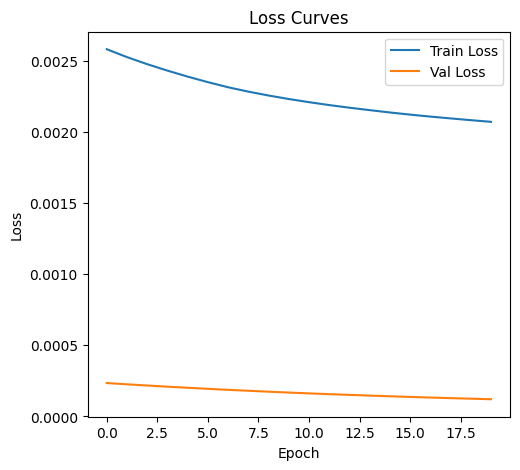

In [31]:
# 训练和验证
num_epochs = 200
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs  = inputs.to(device)
        labels= labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = (outputs.squeeze() > 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss /= len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs= inputs.to(device)
            labels=labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)

            val_loss += loss.item()
            preds = (outputs.squeeze() > 0.5).float()
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    if epoch%50==0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.12f}, Train Acc: {train_accuracy:.12f}, Val Loss: {val_loss:.12f}, Val Acc: {val_accuracy:.12f}')

# 绘制损失曲线
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

In [32]:
#test
bags_list=create_time_windows(data_test, time_step=time_step, overlapping=overlapping, overlap_ratio=overlap_ratio,n=n)
statistics_result = statistics_comp(bags_list)
statistics_result = delete_label(statistics_result)
#X=add_correlation_features(statistics_result,bags_list)
if feature_filter:
    X_test=statistics_result[:,:,selected_index]
else:
    X_test=statistics_result[:,:,:-1]
#X_test=statistics_result
test_result=torch.round(model(torch.tensor(X_test,dtype=torch.float32).to(device))).to(torch.int32).cpu().numpy().reshape(-1)
raw_data_test=pd.read_csv(r'/kaggle/input/dataset/test.csv')
test_df=test_df_func(raw_data_test,test_result,threshold=100)
for i in [650,651,652,653,654]:
    test_df.loc[len(test_df)] = [i, 0]
test_df=test_df.sort_values(by=['RingNumber'], ascending=[True])
test_df.columns=['RingNmuber',	'Instability']
test_df[test_df['Instability']==1]

,RingNmuber,Instability
111,717,1
116,722,1
141,747,1
142,748,1
143,749,1
144,750,1
145,751,1
146,752,1
155,761,1
171,777,1


In [20]:
test_df.to_csv('output.csv',index=False, header=True)